In [51]:
from pycalphad import Database, equilibrium, variables as v
import numpy as np
import collections
dbf = Database('alzn_mey.tdb')
comps = ['AL', 'ZN', 'VA']
phases = sorted(dbf.phases.keys())
solid_phases = sorted(set(phases)-{'LIQUID','GAS'})
temp = 850 # K, Needs to be at or above the liquidus temperature
initial_comp = {v.X('ZN'): 0.3}

x_liquid = [initial_comp]
fraction_solid = [0.0]
temperatures = [temp]

while fraction_solid[-1] < 1:
    conds = {v.T: temp, v.P: 101325}
    conds.update(x_liquid[-1])
    eq = equilibrium(dbf, comps, phases, conds)
    if 'LIQUID' not in eq.Phase.isel(T=0,P=0).values:
        break
    # TODO: Will break if there is a liquid miscibility gap
    liquid_vertex = sorted(np.nonzero(eq.Phase.isel(T=0,P=0).values.flat == 'LIQUID'))[0]
    liquid_comp = {comp: float(eq.X.isel(T=0,P=0,vertex=liquid_vertex).sel(component=str(comp)[2:]).values) for comp in initial_comp.keys()}
    x_liquid.append(liquid_comp)
    current_fraction_solid = float(fraction_solid[-1])
    for solid_phase in solid_phases:
        if solid_phase not in eq.Phase.isel(T=0,P=0).values:
            continue
        # TODO: Will break if there is a miscibility gap
        solid_vertex = sorted(np.nonzero(eq.Phase.isel(T=0,P=0).values.flat == solid_phase))[0]
        solid_comp = {comp: float(eq.X.isel(T=0,P=0,vertex=solid_vertex).sel(component=str(comp)[2:]).values) for comp in initial_comp.keys()}
        delta_comp = liquid_comp[sorted(initial_comp.keys())[0]] - solid_comp[sorted(initial_comp.keys())[0]]
        delta_liquid_comp = x_liquid[-1][sorted(initial_comp.keys())[0]] - x_liquid[-2][sorted(initial_comp.keys())[0]]
        delta_fraction_solid = (1-current_fraction_solid) * delta_liquid_comp / delta_comp
        current_fraction_solid += delta_fraction_solid
        
    fraction_solid.append(current_fraction_solid)
    temperatures.append(temp)
    temp -= 1
if fraction_solid[-1] < 1:
    x_liquid.append(collections.defaultdict(lambda:np.nan))
    fraction_solid.append(1.0)
    temperatures.append(temp)

# Compute the equilibrium solidification path
conds = {v.T: temperatures, v.P: 101325}
conds.update(initial_comp)
eq = equilibrium(dbf, comps, phases, conds)

Exception ignored in: 'pycalphad.core.eqsolver.add_new_phases'
ValueError: Buffer has wrong number of dimensions (expected 2, got 3)
Exception ignored in: 'pycalphad.core.eqsolver.add_new_phases'
ValueError: Buffer has wrong number of dimensions (expected 2, got 3)


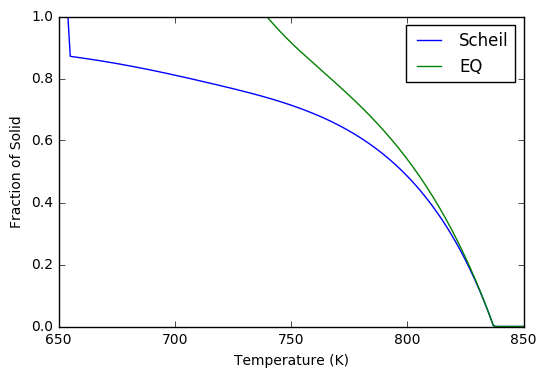

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(temperatures, fraction_solid, label='Scheil')
plt.plot(temperatures, 1-np.nansum(eq.where(eq.Phase=='LIQUID')['NP'].values, axis=-1).flatten(), label='EQ')
plt.legend(loc='best')
plt.xlabel('Temperature (K)')
plt.ylabel('Fraction of Solid')

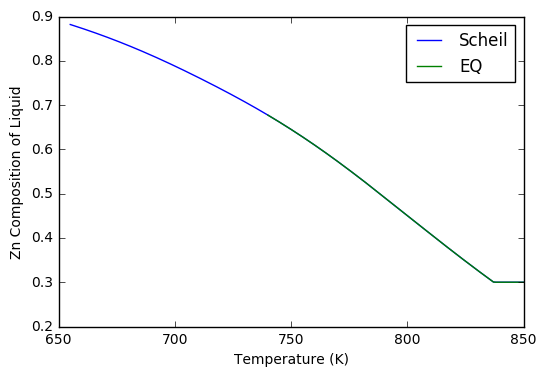

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(temperatures, [x[v.X('ZN')] for x in x_liquid], label='Scheil')
eq_compositions = np.nansum(eq.where(eq.Phase=='LIQUID').X.sel(component='ZN'), axis=-1).flatten()
# Hack, since these should be completely solid
eq_compositions[np.where(eq_compositions==0)] = np.nan
plt.plot(temperatures, eq_compositions, label='EQ')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Zn Composition of Liquid')